In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [203]:
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn import model_selection
from keras import models, layers
from sklearn.preprocessing import RobustScaler
import os
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import matplotlib

import platform
if platform.system() == 'Windows': 
    matplotlib.rc('font', family='Malgun Gothic') 
elif platform.system() == 'Darwin': # Mac 
    matplotlib.rc('font', family='AppleGothic') 
else:
    matplotlib.rc('font', family='NanumGothic')
matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.style.use('ggplot')

In [204]:
dataset = pd.read_csv('/content/drive/MyDrive/bigcon/final_final_train_0913.csv',index_col=0)

In [244]:
len(dataset.columns)

16

In [245]:
dataset.columns

Index(['base_date', 'emd_nm', 'em_g', 'total_pop', 'jeju_resd_pop',
       'card_use_amt', 'delivery_amt', 'market_amt', 'card_use_cnt',
       'delivery_cnt', 'market_cnt', 'em_cnt', 'visit_pop', 'work_pop',
       'youth_pop', 'total_frgn_pop'],
      dtype='object')

In [267]:
def emd_scaler(data,emd_nm):
  tmp = data[data['emd_nm'] == emd_nm].set_index('base_date')
  scaler = RobustScaler()
  # 스케일을 적용할 column을 정의합니다.
  scale_cols = tmp.columns[1:]
  # 스케일 후 columns
  scaled = scaler.fit_transform(tmp[scale_cols])
  df = pd.DataFrame(scaled, columns=scale_cols)
  df = df.reset_index()
  return df, scaler

In [268]:
def create_dataset(data,emd_nm):
  temp_df, scaler = emd_scaler(data,emd_nm)
  #temp_df = data[data['emd_nm'] == emd_nm]
  #temp_df.drop(columns=['base_date','emd_nm'])
  x_train, x_test, y_train, y_test = train_test_split(temp_df.drop('em_g', 1), temp_df['em_g'], test_size=0.2, random_state=0, shuffle=False)
  return x_train, x_test, y_train, y_test, scaler

In [295]:
x_train, x_test, y_train, y_test, target_scaler = create_dataset(dataset,'건입동')

In [275]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [276]:
WINDOW_SIZE=7
BATCH_SIZE=64

In [277]:
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [278]:
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (64, 7, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (64, 1)


In [343]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda, Dropout, Flatten, BatchNormalization
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=256, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(256, activation='tanh', return_sequences=True),
    LSTM(256, activation='tanh',return_sequences=True),
    LSTM(128, activation='tanh',return_sequences=True),
    LSTM(128, activation='tanh'),
    Dense(128, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(32, activation='tanh'),
    Dense(1),
])

In [344]:
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [345]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('/content/drive/MyDrive/bigcon','tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

삽질연대기....

In [346]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=100, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/100
16/16 [==============================] - 12s 290ms/step - loss: 0.2040 - mse: 0.4673 - val_loss: 0.1761 - val_mse: 0.4028

Epoch 00001: val_loss improved from inf to 0.17615, saving model to /content/drive/MyDrive/bigcon/tmp/ckeckpointer.ckpt
Epoch 2/100
16/16 [==============================] - 3s 171ms/step - loss: 0.1740 - mse: 0.4007 - val_loss: 0.2097 - val_mse: 0.5046

Epoch 00002: val_loss did not improve from 0.17615
Epoch 3/100
16/16 [==============================] - 3s 179ms/step - loss: 0.1736 - mse: 0.4029 - val_loss: 0.1656 - val_mse: 0.3951

Epoch 00003: val_loss improved from 0.17615 to 0.16561, saving model to /content/drive/MyDrive/bigcon/tmp/ckeckpointer.ckpt
Epoch 4/100
16/16 [==============================] - 3s 176ms/step - loss: 0.1732 - mse: 0.4030 - val_loss: 0.1889 - val_mse: 0.4541

Epoch 00004: val_loss did not improve from 0.16561
Epoch 5/100
16/16 [==============================] - 3s 176ms/step - loss: 0.1772 - mse: 0.4096 - val_loss: 0.1621 - 

In [347]:
model.load_weights(filename)

In [348]:
pred = model.predict(test_data)

In [349]:
y_test.shape

(256,)

In [350]:
pred.shape

(249, 1)

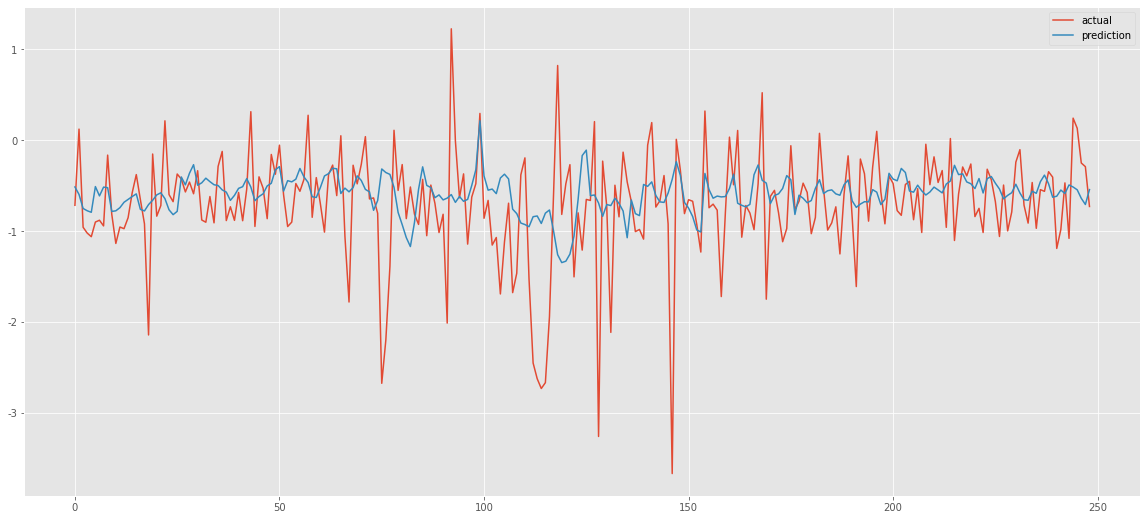

In [351]:
plt.figure(figsize=(20, 9))
plt.plot(np.asarray(y_test)[7:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [310]:
from sklearn.metrics import mean_squared_error
#x_train, x_test, y_train, y_test = train_test_split(temp_df.drop('em_g', 1), temp_df['em_g'], test_size=0.2, random_state=0, shuffle=False)
#pred = target_scaler.inverse_transform(pred)
mean_squared_error(y_test[7:],pred, squared=False)

0.6228353619618338